# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
from google.colab import drive
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Importo los modelos que voy a usar/probar:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Librerías de optimización de modelos:
from sklearn.model_selection import RandomizedSearchCV


# Defino matriz de confusión: 

def confusion(ytest,y_pred):
    names=["0","1"]
    cm=confusion_matrix(ytest,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax) #fmt=".0f",
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Luego se procede a cargar los datos. En mi caso opto por montarlo desde google drive.

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
datos_acum=pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/covid-tests-cases-deaths-per-million.csv')

#Análisis exploratorio de datos

Para empezar unificamos los paises

In [ ]:
paises_unicos = datos_acum.Entity.unique()

Analizamos los estadísticos del dataset.

In [ ]:
datos_acum.describe()

,total_tests_per_thousand,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
count,5.647100e+04,124598.000000,113515.000000
mean,4.949822e+05,19392.944650,398.836624
std,1.207045e+06,32220.897823,657.037212
min,0.000000e+00,0.001000,0.000000
25%,2.278350e+04,406.194000,11.810000
50%,1.153630e+05,3137.422000,79.707000
75%,4.562925e+05,24527.508750,515.620000
max,1.679056e+07,236571.552000,6008.439000


In [ ]:
datos_acum.corr()

,total_tests_per_thousand,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
total_tests_per_thousand,1.000000,0.543076,0.241757
Total confirmed cases of COVID-19 per million people,0.543076,1.000000,0.777852
Total confirmed deaths due to COVID-19 per million people,0.241757,0.777852,1.000000


#####Como se puede ver, encontramos una gran diferencia en cuanto a cantidad de datos obtenidos, por un lado la cantidad de testeos, como era de esperarse, es muy superior a la cantidad de contagios y aun mas notoria en cantidad de muertes. Por otro lado, hay maximos que se alejan mucho de la media, esto se debe a que los paises tomarno diferentes medidas frente a esta enfermedad y segun que tan preparados se encontraban en el momento que hubieron brotes. Por otro lado en el cuadro de correlación podemos obtener la hipotesis de que a mayor cantidad de contagios, mayor cantidad de muertes, y que la cantidad de testeos no tiene relación alguna con la cantidad de muertes y contagios.

Ahora analizamos los valores faltantes.

In [ ]:
nombre_columnas_ = datos_acum.columns 
bool_mat = datos_acum.isna()
tamaño_con_nans = datos_acum.shape


print('Dataset de casos y muertes acumuladas')
print('----------')
print('Tamaño de datos: ',tamaño_con_nans)
print('----------')

faltantes = []
for nombre in nombre_columnas_: # Voy iterando el nombre del vector nombre_columnas con un for.
  print('Falantes en: ',nombre,': ',sum(bool_mat[nombre]),' valores.')
  faltantes.append(sum(bool_mat[nombre]))

datos_acum.head(2)

Dataset de casos y muertes acumuladas
----------
Tamaño de datos:  (126355, 7)
----------
Falantes en:  Entity :  0  valores.
Falantes en:  Code :  9243  valores.
Falantes en:  Day :  0  valores.
Falantes en:  total_tests_per_thousand :  69884  valores.
Falantes en:  142605-annotations :  71530  valores.
Falantes en:  Total confirmed cases of COVID-19 per million people :  1757  valores.
Falantes en:  Total confirmed deaths due to COVID-19 per million people :  12840  valores.


,Entity,Code,Day,total_tests_per_thousand,142605-annotations,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
0,Afghanistan,AFG,2020-02-24,NaN,NaN,0.126,NaN
1,Afghanistan,AFG,2020-02-25,NaN,NaN,0.126,NaN


In [ ]:
#datos=pd.read_csv(covid_tests_cases_deaths)
paises=datos_acum['Entity'] #cargo el vector de paises
#confirmados=datos['Total confirmed cases of COVID-19'] #carga vector todos los casos confirmados

confirmados= datos_acum['Total confirmed cases of COVID-19 per million people']

Text(0.5, 1.0, 'Casos a lo largo de la pandemia en Argentina')

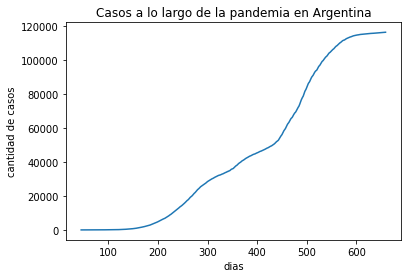

In [ ]:
#seleccionamos Argentina

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.title('Casos a lo largo de la pandemia en Argentina')

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0.5, 1.0, 'Casos en escala logaritmica en Argentina')

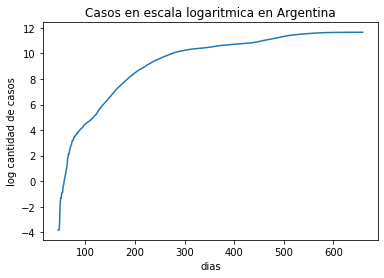

In [ ]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.title('Casos en escala logaritmica en Argentina')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0.5, 1.0, 'Casos al dia 60 en Argentina')

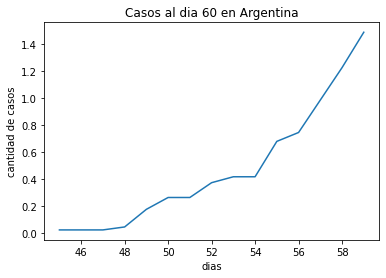

In [ ]:
casos_principio=casos_arg[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.title('Casos al dia 60 en Argentina')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0.5, 1.0, 'Casos al dia 60 con escala logaritmica en Argentina')

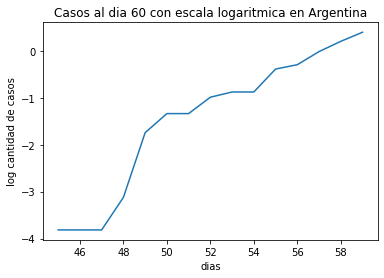

In [ ]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.title('Casos al dia 60 con escala logaritmica en Argentina')

Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

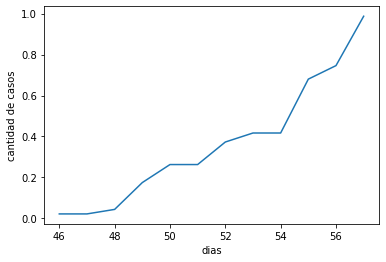

In [ ]:
casos_principio=casos_arg[46:58]
dias_principio=dias[46:58]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

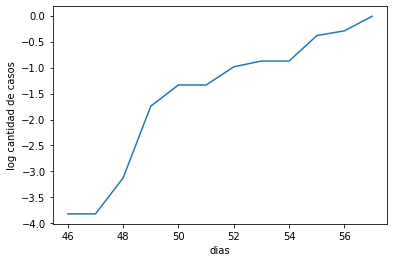

In [ ]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [ ]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [ ]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.23093272, 57.06239595])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

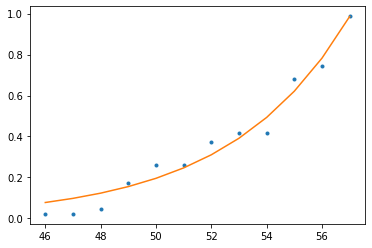

In [ ]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [ ]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

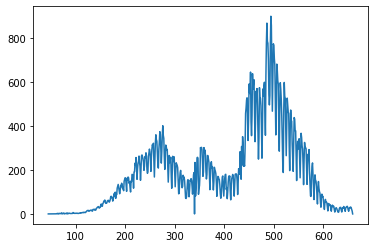

In [ ]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

# Parte 1

Analizo curvas de casos $Confirmados=e^{k(t-t_0)}$ por millón para los 10 países que elegí.

In [ ]:
## Elección de cortes de días para los distitnos países:
paises = ['Bahrain', 'Belgium','Cuba', 'Denmark', 'Finland','Ireland','Mexico', 'Nepal', 'Russia', 'South Korea']
data_select = datos_acum[(datos_acum['Entity'].isin(paises))]
data_world  = datos_acum[(datos_acum['Entity'].isin(['World']))]

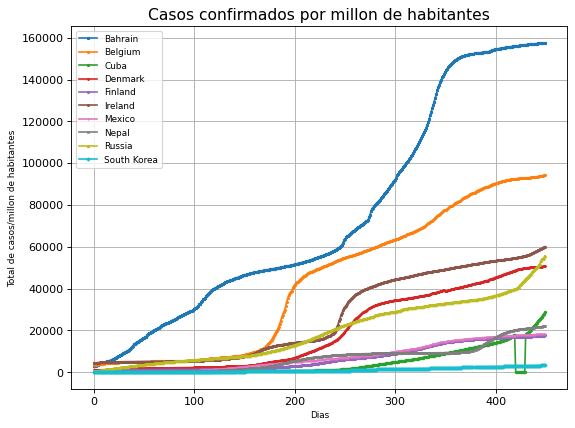

In [ ]:
i = 0
scale = 2
plt.figure(figsize=(4*scale, 3*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D","."]

for pais in paises:
   casos_pais = data_select['Total confirmed cases of COVID-19 per million people'][(data_select.Entity == pais)][50:500]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 2)
   i = i + 1

plt.title('Casos confirmados por millon de habitantes', fontsize = 14)
plt.legend(fontsize = 8)
plt.ylabel('Total de casos/millon de habitantes', fontsize = 8)
plt.xlabel('Dias', fontsize = 8)
plt.grid()
plt.show()

Como se puede ver los paises con mayor afección en proporción a la cantidad de habitantes son Bahrein y en segundo lugar Belgica, ambos paises cuentan con un territorio de dimensiones muy reducidas y una alta densidad poblacional, por lo tanto se puede deducir que a mayor densidad poblacional el virus se expande con mayor facilidad.

In [ ]:
data_select = data_select.fillna(0)

A continuación se tomará el intervalo de días desde el 0 al 100 para analizar como afecto a los paises seleccionados esta enfermedad.

In [ ]:
dataFiltrada = {'Pais':  ['Bahrain', 'Belgium','Cuba', 'Denmark', 'Finland','Ireland','Mexico', 'Nepal', 'Russia', 'South Korea'],
        'DiaInicial': [0,0,0,0,0,0,0,0,0,0],
         'DiaFinal': [100,100,100,100,100,100,100,100,100,100]}

df = pd.DataFrame(dataFiltrada)

In [ ]:
ks = []
for i in range(df.shape[0]):
  casosParaCalcularK = data_select['Total confirmed cases of COVID-19 per million people'][(data_select.Entity == df.Pais[i])][df.DiaInicial[i]:df.DiaFinal[i]]
  popt, pcov = curve_fit(exponencial, np.arange(df.DiaInicial[i],df.DiaFinal[i]), casosParaCalcularK, maxfev = 2000)
  ks.append(popt[0])
df['Ks'] = ks
df

,Pais,DiaInicial,DiaFinal,Ks
0,Bahrain,0,100,0.036145
1,Belgium,0,100,0.019516
2,Cuba,0,100,0.014522
3,Denmark,0,100,0.024422
4,Finland,0,100,0.022293
5,Ireland,0,100,0.013436
6,Mexico,0,100,0.127973
7,Nepal,0,100,0.112939
8,Russia,0,100,0.035674
9,South Korea,0,100,0.018782


In [ ]:
d_world = np.arange(0,101)
casos_world  = data_world['Total confirmed cases of COVID-19 per million people'][(data_world.Entity == 'World')][0:101]
popt_world, pcov_world = curve_fit(exponencial, d_world , casos_world, maxfev = 2000)
k_world = popt_world[0]
k_world

0.04756098556107505

Bootstraping e intervalo de confianza:

In [ ]:
def remuestreo(datos_acum):
  remuestra=np.zeros(len(datos_acum))
  i=0
  while i<len(datos_acum):
    remuestra[i]=datos_acum[np.random.randint(len(datos_acum))]
    i=i+1
  return remuestra  

No handles with labels found to put in legend.


Text(0.5, 0, 'K')

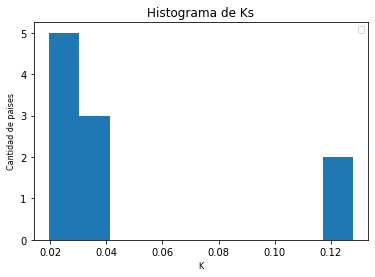

In [ ]:
datos_rem=remuestreo(df.iloc[:,3])
plt.hist(datos_rem)
plt.title('Histograma de Ks', fontsize = 12)
plt.legend(fontsize = 8)
plt.ylabel('Cantidad de paises', fontsize = 8)
plt.xlabel('K', fontsize = 8)

No handles with labels found to put in legend.


0.04298180912322741


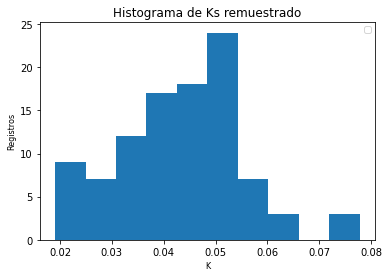

In [ ]:
np.random.seed(10) # Elegir semilla.
nrep = 100
datos_100 = df.iloc[:,3]
medias = []

for i in np.arange(nrep):
  datos_rem=remuestreo(datos_100)
  medias.append(np.mean(datos_rem))

plt.hist(medias)
mu_muestra = np.mean(medias)
sigma_muestra = np.std(medias)
plt.title('Histograma de Ks remuestrado', fontsize = 12)
plt.legend(fontsize = 8)
plt.ylabel('Registros', fontsize = 8)
plt.xlabel('K', fontsize = 8)
print(np.mean(medias))

Si $\alpha=0.05$ ------> $z_{alpha}=1.96$.

In [ ]:
## Intervalo de conf:
z=1.96
n=len(medias)
int_conf=[mu_muestra-z*sigma_muestra/np.sqrt(n),mu_muestra+z*sigma_muestra/np.sqrt(n)]
print(int_conf)

[0.04063695737428049, 0.04532666087217433]


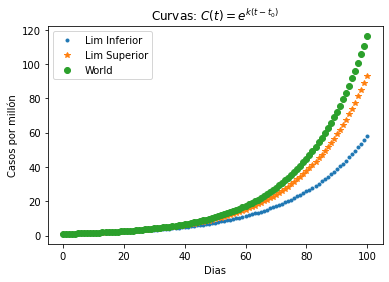

In [ ]:
# Graficos de curvas:
k_min = int_conf[0]
k_max = int_conf[1]
k_mundo = k_world

dias_principio = np.arange(0,101)

casos_simu_min=exponencial(dias_principio,k_min,0)
casos_simu_max=exponencial(dias_principio,k_max,0)
casos_simu_world=exponencial(dias_principio,k_mundo,0)
plt.plot(dias_principio,casos_simu_min,'.', label = 'Lim Inferior')
plt.plot(dias_principio,casos_simu_max,'*', label = 'Lim Superior')
plt.plot(dias_principio,casos_simu_world,'o', label = 'World')
plt.title('Curvas: $C(t)=e^{k(t-t_0)}$')
plt.xlabel('Dias')
plt.ylabel('Casos por millón')
plt.legend()
plt.show()

###CONCLUSION PRIMERA PARTE:
Luego de realizar un bootstraping con un intervalo de confianza del 95% podemos decir que la curva que modela la disipación del virus a nivel mundial no se encontrará dentro del intervalo (limite superior y limite inferior) que nos devuelve el modelo realizado para los paises analizados desde el dia 1 al 100 de la pandemia. Los K que marcan los limites del intervalo de confianza son: 0.0406369573663654, 0.0453266608572173, mientras que el k mundial esta por encima de los mismos siendo: 0.047560984760329585. Esto puede darse por una elección  de paises que no son representativos de la disipación del virus a nivel mundial.

#Segunda parte
En esta parte del proyecto se tomarán 6 paises que hayan realizado una estricta cuarentena y 6 naciones que no hayan hecho cuarentena por cuestiones economicas.
A estos se los clasificará con un 0 a los que no hayan hecho cuarentena y con un 1 a quienes si hicieron con motivo de luego realizar un modelo predictivo que nos devuelva el comportamiento de cada pais. 

In [ ]:
dataClas0 = ['Brazil','United States','Uruguay','Mexico','South Korea','Singapore']
dataClas1 = ['Italy','Spain','Germany','France','United Kingdom','Peru']
dataClas = {'Pais': dataClas0+dataClas1,'Clase':np.concatenate((np.repeat(0,6),np.repeat(1,6)))}
df2 = pd.DataFrame(dataClas)
df2

,Pais,Clase
0,Brazil,0
1,United States,0
2,Uruguay,0
3,Mexico,0
4,South Korea,0
5,Singapore,0
6,Italy,1
7,Spain,1
8,Germany,1
9,France,1


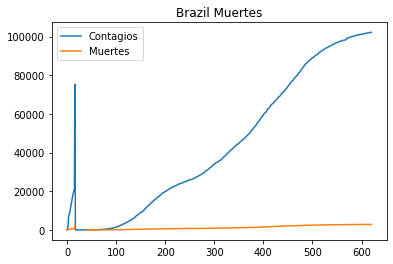

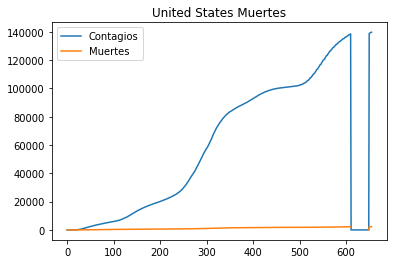

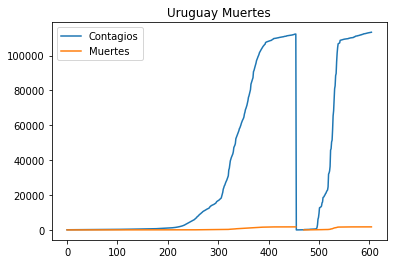

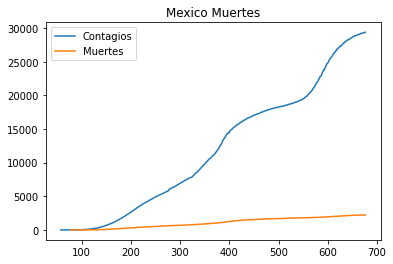

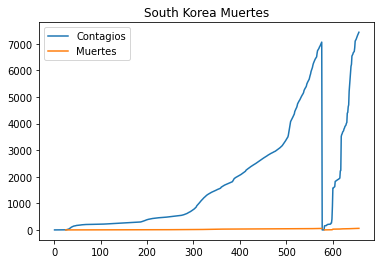

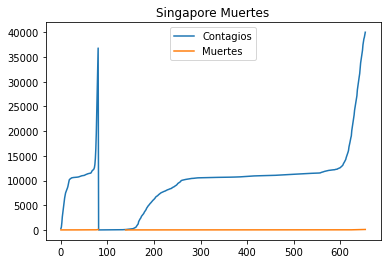

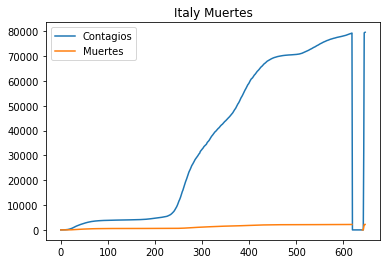

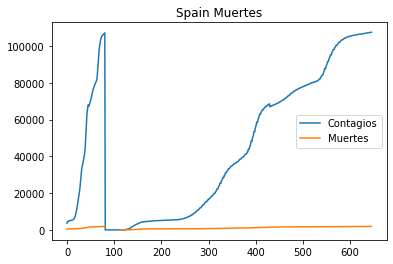

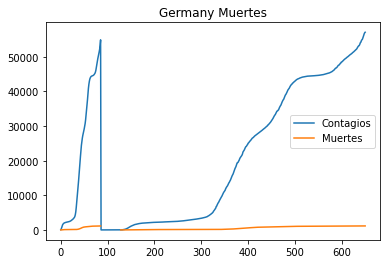

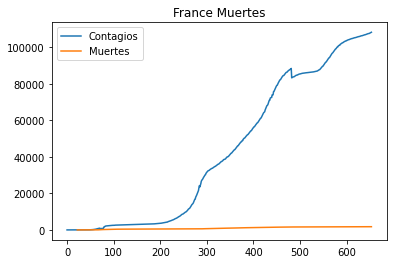

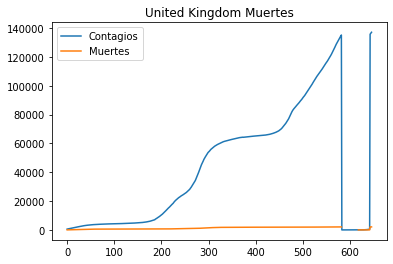

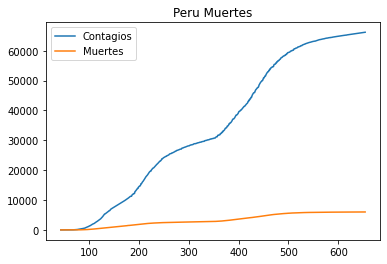

In [ ]:
## Calculo de las k:
# Las voy a calcular en función de los datos de:
casos = 'Total confirmed cases of COVID-19 per million people'
muertes  = 'Total confirmed deaths due to COVID-19 per million people'

## Exploratioria de charts de muertes y casos de países que no hiciero cuarentena:
# La idea es ver en que intervalo de dias tomar los datos tanto para casos como para muertes
# y ver que comportamiento tiene la curva de muertes: Expoencial u otra.

## Países sin cuarentena:

i = 0
paises = dataClas0 + dataClas1
for pais in paises:
   casos_pais = datos_acum[casos][(datos_acum.Entity == pais)]
   muertes_pais = datos_acum[muertes][(datos_acum.Entity == pais)]
   dias = np.arange(casos_pais.shape[0]) 
   plt.figure(i)
   plt.plot(dias,casos_pais,label = 'Contagios')
   plt.title(pais + ' Casos')
   plt.legend()

   plt.figure(i)
   plt.plot(dias,muertes_pais,label = 'Muertes')
   plt.title(pais + ' Muertes')
   plt.legend()
   plt.show()
   i = i + 1

Estos gráficos muestran las curvas de contagios y muertes, como la cantidad de contagios es sumamente superior a la de muertes, a simple vista no se puede deducir si esto tendrá una relación, y al no poder verse la relación no se podrá deducir si los paises que realizaron cuarentena tendrán ventaja en cuanto 
a la preparación del sistema sanitario y si se ralentizo la difusión del virus.
Por convenciencia voy a tomar el intervalo de días: 200 a 400 debido a que este parece ser el promedio común de comportamiento exponencial de ambas curvas, tanto la de muertes por millon como la de contagios, que responden a estos modelos:

- $Contagios=e^{k_{contagios}(t-t_0)}$
- $Muertes=e^{k_{muertes}(t-t_0)}$
- $Ratio = Media Contagios / Media Muertes$

In [ ]:
i = 0
for pais in paises:
    casos_pais = datos_acum[casos][(datos_acum.Entity == pais)][200:401]
    muertes_pais = datos_acum[muertes][(datos_acum.Entity == pais)][200:401]
    ratio_muertes_casos = np.mean(casos_pais)/np.mean(muertes_pais)
    dias = np.arange(200,401) 
    popt_casos , pcov_casos  = curve_fit(exponencial, dias, casos_pais, maxfev = 2000)       # Fiteo las exponenciales de casos.
    popt_muert , pcov_muert  = curve_fit(exponencial, dias, muertes_pais, maxfev = 2000)     # Fiteo las exponenciales de muertes.
    # Inserto los datos al df que voy a usar para hacer el modelo:
    df2.loc[i,('k_contagios')]          =  popt_casos[0]
    df2.loc[i,('k_muertes')]       =  popt_muert[0]
    df2.loc[i,('Letalidad')] =  ratio_muertes_casos
    i = i + 1

In [ ]:
# Data final:
df2 = df2.sample(frac=1).reset_index(drop=True) # Hago un shuffle.
df2

,Pais,Clase,k_contagios,k_muertes,Letalidad
0,Singapore,0,0.993825,0.990972,1966.908826
1,South Korea,0,0.991439,0.992212,59.335966
2,Mexico,0,0.991810,0.994835,10.473833
3,United States,0,0.992888,0.992994,52.634180
4,Italy,1,0.987772,0.992460,26.635949
5,Germany,1,0.994889,0.993604,42.780658
6,Spain,1,0.988802,0.995002,27.023205
7,France,1,0.988459,0.994657,36.383137
8,Brazil,0,0.987753,0.993847,38.481057
9,Uruguay,0,0.991677,0.992983,73.499459


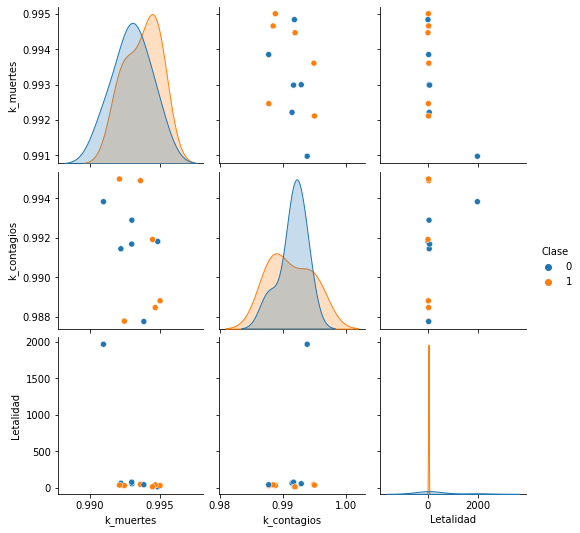

In [ ]:
sns.pairplot(data=df2[['k_muertes','k_contagios',	'Letalidad',	'Clase']],hue = 'Clase')

Luego de divisar el Pairplot no podemos realizar absolutamente ninguna conclusion debido a que ambas clases (1: Hizo cuarentena, 0: No hizo cuarentena) se encuentran completamente mezcladas. Asique se procederá a realizar dos modelos predictivos de clasificación a ver si se puede obtener la variable target. 

###MODELOS
Primero debemos separar la variable target y los atributos que nos serviran para predecir esta variable.

In [ ]:
X = df2[['k_muertes','k_contagios','Letalidad']]
y = df2[['Clase']] 

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

##Naive Bayes:
A traves de este modelo comparamos el Linear SVC con el XGBoost y con este metodo estimar la variable target.

In [ ]:
NaiveBayes = GaussianNB() 
NaiveBayes.fit(x_train,np.array(y_train).ravel())

GaussianNB()

Ahora obtendrémos la grafica y los resultados para evaluar como funciona este modelo.

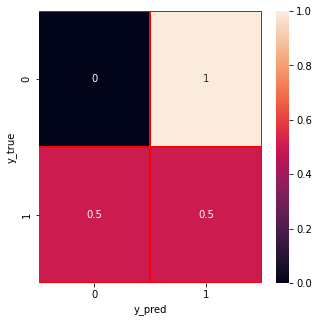

acc :  0.25
F1 Score:  0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4



In [ ]:
y_pred_nb = NaiveBayes.predict(x_test)
confusion(y_test,y_pred_nb)

print("acc : ",accuracy_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test ,y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))

#Regresion Logística
Ahora aplicaremos el análisis de regresión para predecir el resultado de la variable categórica.

In [ ]:
RegLog = LogisticRegression()
RegLog.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Ahora obtendrémos la grafica y los resultados para evaluar como funciona este modelo.

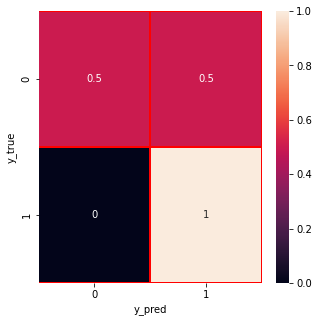

acc :  0.75
F1 Score:  0.7333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [ ]:
y_pred_logreg = RegLog.predict(x_test)
confusion(y_test,y_pred_logreg)

print("acc : ",accuracy_score(y_test, y_pred_logreg))
print("F1 Score: ", f1_score(y_test ,y_pred_logreg, average='macro'))
print(classification_report(y_test, y_pred_logreg))

#CONCLUSION SEGUNDA PARTE
A modo de conclusión se puede destacar que el mejor modelo a traves de todos los indicadores es el modelo realizado a traves de regresion logística. En el mismo podemos observar que obtenemos un accuracy del 0.75, lo cual es algo aceptable, por lo menos aproxima mejor que el azar y el F1 Score tambien da en el orden del 0.73 por lo tanto el modelo sirve.
En cuanto al modelo de Naive Bayes los resultados son peores que el azar por lo tanto podemos decir que no servirá este modelo.

#CONCLUSION FINAL

A modo de conclusion final determino que la complejidad de una enfermedad tan repentina y desconocida que involucra diversos factores como son el factor social, el factor económico, el desarrollo del sector salud de cada pais, y hasta cuestiones estacionarias, es tan grande que es imposible realizar un análisis tan global y general como el que se esta planteando en este proyecto. Para generar un buen modelo se debe contar con mayor cantidad de información, tener datos que alimenten mas a los modelos, y siempre se va a tener una cierta falla porque tambien esta involucrado el factor social que es poco cuantificable, ya que no es facil ponerle un valor numerico al comportamiento de la población cuando el gobierno decreto o no la cuarentena obligatoria. Se vio que en paises que no han tenido cuarentena los resultados fueron superiores a paises que si tuvieron, por lo tanto las variables van a perder verosimilitud. Por lo tanto concluyo con con esta información proveida no podemos obtener una conclusión certera respecto a la difusión del virus y la relación entre contagios y muertes.

